## Data Cleaning Test

In [283]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, filtfilt, detrend
import numpy as np
from sklearn.preprocessing import RobustScaler

In [284]:
def load_io_dataset(base_path: str) -> pd.DataFrame:
    """Load all IO dataset files with proper structure"""
    base_path = Path(base_path)
    data_files = list(base_path.glob("EEG-IO/S*_data.csv"))
    
    if not data_files:
        raise FileNotFoundError(f"No IO data files found in {base_path/'EEG-IO'}")

    all_data = []
    
    for data_file in data_files:
        # Load EEG data with correct column mapping
        df = pd.read_csv(
            data_file, 
            sep=';',  # Files use semicolon separators
            header=0,  # First line contains headers
            usecols=['Time (s)', 'FP1', 'FP2'],  # Select relevant columns
            dtype={'Time (s)': 'float32', 'FP1': 'float32', 'FP2': 'float32'}
        )
        
        # Convert time to sample index (250Hz sampling rate)
        df['SampleIndex'] = (df['Time (s)'] * 250).astype('int32')
        df = df[['SampleIndex', 'FP1', 'FP2']]
        
        # Load corresponding labels
        label_file = data_file.parent / data_file.name.replace('_data.csv', '_labels.csv')
        labels = load_io_labels(label_file)
        
        # Merge labels with EEG data
        df = pd.merge(df, labels, on='SampleIndex', how='left')
        df['Blink'] = df['Blink'].fillna(0).astype('int8')
        
        all_data.append(df)
    
    return pd.concat(all_data).reset_index(drop=True)

def load_io_labels(label_file: Path) -> pd.DataFrame:
    """Parse IO label files with corrupt intervals and blink markers"""
    if not label_file.exists():
        raise FileNotFoundError(f"Label file missing: {label_file}")
    
    with open(label_file) as f:
        lines = [line.strip() for line in f if line.strip()]
    
    # Parse corrupt intervals (we'll just log these for now)
    corrupt = []
    if lines[0].startswith('corrupt'):
        n_corrupt = int(lines[0].split(',')[-1])
        corrupt = [tuple(map(float, line.split(','))) 
                 for line in lines[1:1+n_corrupt]]
    
    # Parse blinks (our main focus)
    blinks = []
    blink_start = lines.index('blinks') + 1
    for line in lines[blink_start:]:
        time, code = line.split(',')
        blinks.append({
            'SampleIndex': int(float(time) * 250),  # Convert to samples
            'Blink': 1,
            'TrialType': int(code)  # 1 indicates involuntary blink in IO dataset
        })
    
    return pd.DataFrame(blinks)

In [285]:
try:
    io_data = load_io_dataset("EEG-EyeBlinks/")
    print(io_data[['SampleIndex', 'FP1', 'FP2', 'Blink']].head())
except Exception as e:
    print(f"Error loading data: {str(e)}")

   SampleIndex           FP1           FP2  Blink
0            0 -42285.386719 -10093.287109      0
1            0 -42301.187500  -9743.169922      0
2            1 -42525.621094  -9433.911133      0
3            2 -42545.515625  -9755.731445      0
4            3 -42285.476562 -10058.172852      0


In [286]:
def clean_io_data(raw_df: pd.DataFrame, 
                 lowcut: float = 1.0, 
                 highcut: float = 30.0,
                 fs: float = 250.0) -> pd.DataFrame:
    """
    Clean and preprocess IO dataset with:
    - Bandpass filtering
    - Blink artifact handling
    - Normalization
    - Outlier removal
    """
    df = raw_df.copy()
    
    # Filtering
    print("Applying bandpass filter...")
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    # Butterworth bandpass filter
    b, a = butter(4, [low, high], btype='band')
    for col in ['FP1', 'FP2']:
        df[col] = filtfilt(b, a, df[col])
    
    # Remove linear trends
    print("Detrending signals...")
    for col in ['FP1', 'FP2']:
        df[col] = detrend(df[col], type='linear')
    
    # Normalize using robust scaling
    print("Normalizing signals...")
    scaler = RobustScaler()
    df[['FP1', 'FP2']] = scaler.fit_transform(df[['FP1', 'FP2']])
    
    # Handle outliers using IQR
    print("Removing outliers...")
    for col in ['FP1', 'FP2']:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        df[col] = np.clip(df[col], q1 - 1.5*iqr, q3 + 1.5*iqr)
    
    # Create blink-centered epochs
    print("Creating blink epochs...")
    blink_epochs = []
    blink_indices = df[df['Blink'] == 1].index
    epoch_id = 0
    
    for idx in blink_indices:
        epoch_start = max(0, idx - 25)  # 100ms pre-blink
        epoch_end = min(len(df), idx + 100)  # 400ms post-blink
        epoch = df.iloc[epoch_start:epoch_end].copy()
        
        # Add epoch metadata
        epoch['EpochID'] = epoch_id
        relative_peak = idx - epoch_start
        epoch['BlinkPeak'] = 0
        epoch.iloc[relative_peak, epoch.columns.get_loc('BlinkPeak')] = 1
        
        blink_epochs.append(epoch)
        epoch_id += 1
    
    return pd.concat(blink_epochs).reset_index(drop=True)


In [287]:
def plot_cleaning_comparison(raw_df, cleaned_df):
    plt.figure(figsize=(12, 6))
    
    # Raw data plot
    plt.subplot(2, 1, 1)
    plt.plot(raw_df['FP1'].values[:500], label='FP1 Raw')
    plt.plot(raw_df['FP2'].values[:500], label='FP2 Raw')
    plt.title("Raw EEG Signals")
    plt.ylabel("Amplitude (μV)")
    plt.legend()
    
    # Cleaned data plot
    plt.subplot(2, 1, 2)
    plt.plot(cleaned_df['FP1'].values[:500], label='FP1 Cleaned')
    plt.plot(cleaned_df['FP2'].values[:500], label='FP2 Cleaned') 
    plt.title("Cleaned EEG Signals")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Units")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [288]:
def analyze_blink_epochs(cleaned_df):
    """Updated analysis with proper dataframe creation"""
    aligned_epochs = []
    
    # Group by EpochID
    for epoch_id, epoch in cleaned_df.groupby('EpochID'):
        try:
            peak_idx = epoch[epoch['BlinkPeak'] == 1].index[0]
        except IndexError:
            continue  # Skip epochs without peaks
            
        # Convert to relative time
        epoch['TimeFromPeak'] = (epoch.index - peak_idx) / 250
        aligned_epochs.append(epoch)
    
    # Create combined dataframe
    aligned_df = pd.concat(aligned_epochs)
    
    # Plot average blink response
    plt.figure(figsize=(10, 4))
    for channel in ['FP1', 'FP2']:
        avg_response = aligned_df.groupby('TimeFromPeak')[channel].mean()
        plt.plot(avg_response.index, avg_response, label=channel)
    
    plt.axvline(0, color='red', linestyle='--', label='Blink Peak')
    plt.title("Average Blink Response")
    plt.xlabel("Time from Blink Peak (s)")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


Applying bandpass filter...
Detrending signals...
Normalizing signals...
Removing outliers...
Creating blink epochs...


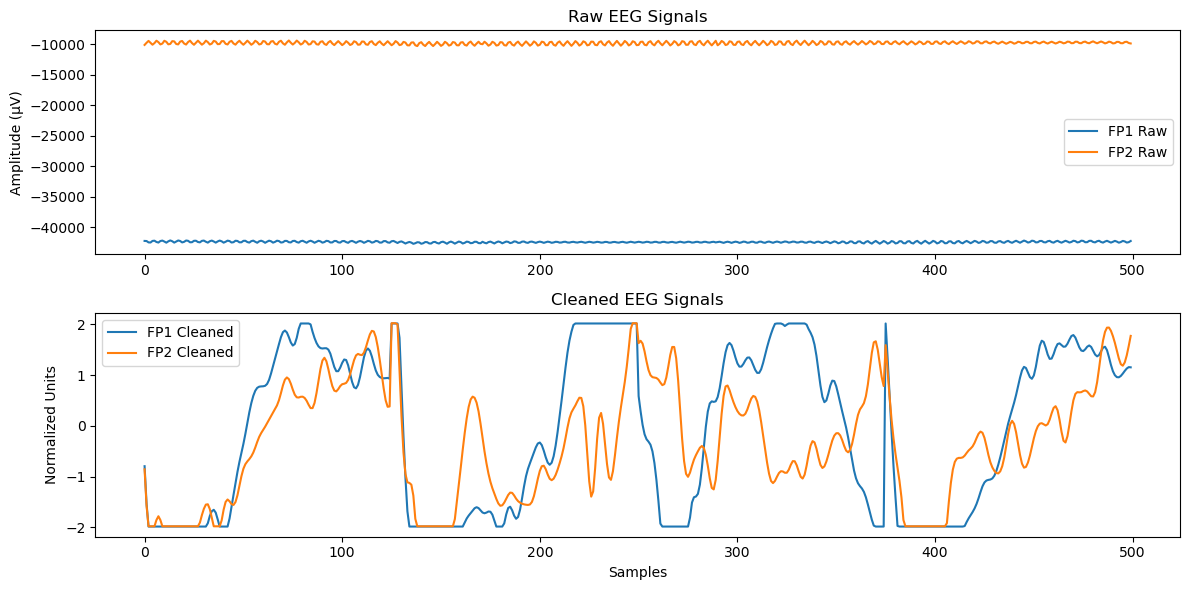

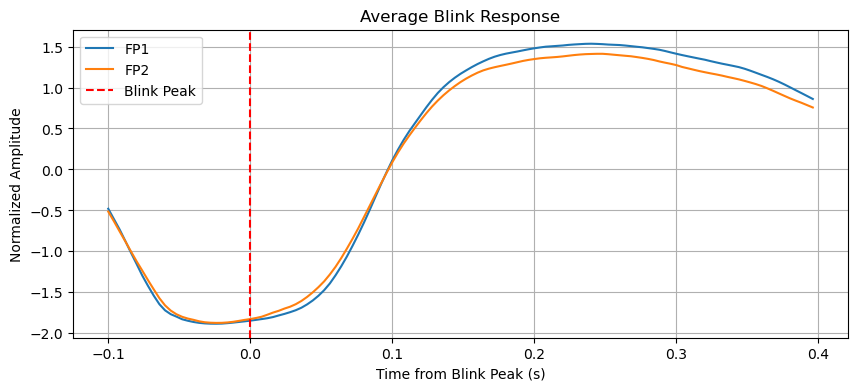

In [289]:
# Load and clean
io_raw = load_io_dataset("EEG-EyeBlinks/")
io_clean = clean_io_data(io_raw)

# Analyze
plot_cleaning_comparison(io_raw, io_clean)
analyze_blink_epochs(io_clean)

# Save cleaned data
io_clean.to_feather("cleaned_io_data.feather")

In [290]:
def load_vr_vv_data(base_path: str, dataset_type: str) -> pd.DataFrame:
    """Final fixed version with complete error handling"""
    base_path = Path(base_path)
    folder = "EEG-VR" if dataset_type == "VR" else "EEG-VV"
    data_files = list(base_path.glob(f"{folder}/S*{'R' if dataset_type == 'VR' else 'V'}_data.csv"))
    
    if not data_files:
        raise FileNotFoundError(f"No {dataset_type} data files found in {base_path/folder}")

    all_data = []
    
    for data_file in data_files:
        # Load EEG data with validation
        try:
            # Read data WITHOUT using the file's sample index
            df = pd.read_csv(
                data_file,
                comment='%',
                header=None,
                skiprows=4,
                usecols=[1, 2],  # Skip first column
                names=['FP1', 'FP2'],  # Remove SampleIndex from names
                dtype={'FP1': 'float32', 'FP2': 'float32'}
            )
            # Add proper sequential index
            df['SampleIndex'] = df.index.astype('int32')  # New line
        except Exception as e:
            print(f"Error loading {data_file}: {e}")
            continue
            
        # Load corresponding labels
        label_file = data_file.parent / f"{data_file.stem.replace('_data', '_labels')}.csv"
        if not label_file.exists():
            print(f"Missing label file: {label_file}")
            continue
            
        try:
            labels = parse_vr_vv_labels(label_file, dataset_type)
        except Exception as e:
            print(f"Error parsing {label_file}: {e}")
            continue

        # Validate label indices against data
        if not labels.empty:
            max_sample = df['SampleIndex'].max()
            label_samples = labels['SampleIndex']
            valid_labels = labels[label_samples <= max_sample]
            
            if len(valid_labels) < len(labels):
                print(f"Warning: {len(labels)-len(valid_labels)} label(s) exceed data length in {data_file}")
        else:
            valid_labels = labels
            
        # Merge and validate
        if not valid_labels.empty:
            df = pd.merge(df, valid_labels, on='SampleIndex', how='left')
        else:
            df['Blink'] = 0
            df['TrialType'] = -1
            
        # Final cleanup
        df['Blink'] = df['Blink'].fillna(0).astype('int8')
        df['TrialType'] = df['TrialType'].fillna(-1).astype('int8')
        df['DatasetType'] = dataset_type
        all_data.append(df)
    
    if not all_data:
        raise ValueError(f"No valid data loaded for {dataset_type} dataset")
    
    return pd.concat(all_data).reset_index(drop=True)

def parse_vr_vv_labels(label_file: Path, dataset_type: str) -> pd.DataFrame:
    """Final fixed label parser with time validation"""
    blinks = []
    try:
        with open(label_file, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
            
        if 'blinks' not in lines:
            print(f"No blink section in {label_file}")
            return pd.DataFrame()
            
        blink_start = lines.index('blinks') + 1
        for line_num, line in enumerate(lines[blink_start:], blink_start+1):
            if not line or ',' not in line:
                continue
                
            try:
                time_str, code = line.split(',', 1)
                time_sec = float(time_str)
                sample_idx = int(round(time_sec * 250))  # Proper rounding
                
                # Validate code before adding
                trial_type = 0 if (dataset_type == 'VR' and int(code) == 0) else 1
                blinks.append({
                    'SampleIndex': sample_idx,
                    'Blink': 1,
                    'TrialType': trial_type
                })
                
            except ValueError as e:
                print(f"Invalid line {line_num} '{line}' in {label_file}: {e}")
                
    except Exception as e:
        print(f"Error reading {label_file}: {e}")
    
    return pd.DataFrame(blinks).astype({
        'SampleIndex': 'int32',
        'Blink': 'int8',
        'TrialType': 'int8'
    })

In [291]:
def clean_vr_vv_data(raw_df: pd.DataFrame,
                    lowcut: float = 0.5,  # Wider band for voluntary blinks
                    highcut: float = 40.0,
                    fs: float = 250.0) -> pd.DataFrame:
    """
    Process VR/VV datasets with:
    - Extended bandpass filtering
    - Voluntary blink handling
    - Trial-type aware processing
    """
    df = raw_df.copy()
    
    # Filtering with wider band
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut/nyq, highcut/nyq], btype='band')
    for col in ['FP1', 'FP2']:
        df[col] = filtfilt(b, a, df[col])
    
    # Remove nonlinear trends
    for col in ['FP1', 'FP2']:
        df[col] = detrend(df[col], type='linear')
    
    # Trial-type specific normalization
    print("Normalizing signals...")
    scaler = RobustScaler()
    for trial_type in df['TrialType'].unique():
        mask = df['TrialType'] == trial_type
        if mask.sum() > 0:  # Only process if samples exist
            df.loc[mask, ['FP1', 'FP2']] = scaler.fit_transform(df.loc[mask, ['FP1', 'FP2']])
        else:
            print(f"Warning: No samples found for trial type {trial_type}")
    
    # Outlier handling with trial-type consideration
    print("Handling outliers...")
    for col in ['FP1', 'FP2']:
        for trial_type in df['TrialType'].unique():
            mask = df['TrialType'] == trial_type
            if mask.sum() > 0:  # Only process if samples exist
                subset = df.loc[mask, col]
                q1 = subset.quantile(0.25)
                q3 = subset.quantile(0.75)
                iqr = q3 - q1
                df.loc[mask, col] = np.clip(subset, q1 - 1.5*iqr, q3 + 1.5*iqr)
    
    # Create voluntary blink epochs (fixed)
    print("Creating blink epochs...")
    blink_epochs = []
    blink_indices = df[df['Blink'] == 1].index
    epoch_id = 0  # Initialize counter
    
    if len(blink_indices) == 0:
        raise ValueError("No blink markers found - check label files and data loading")
    
    for idx in blink_indices:
        # Larger window for voluntary blinks
        epoch_start = max(0, idx - 50)  # 200ms pre-blink
        epoch_end = min(len(df), idx + 150)  # 600ms post-blink
        epoch = df.iloc[epoch_start:epoch_end].copy()
        
        # Add metadata
        epoch['EpochID'] = epoch_id
        epoch['TrialType'] = df.at[idx, 'TrialType']  # Preserve trial type
        relative_peak = idx - epoch_start
        epoch['BlinkPeak'] = 0
        epoch.iloc[relative_peak, epoch.columns.get_loc('BlinkPeak')] = 1
        
        blink_epochs.append(epoch)
        epoch_id += 1  # Increment counter

    if not blink_epochs:
        print("Warning: No valid blink epochs created")
        return pd.DataFrame()
    
    return pd.concat(blink_epochs).reset_index(drop=True)

def plot_vr_vv_comparison(vr_df, vv_df):
    """Compare VR recalibration vs VV voluntary blinks"""
    plt.figure(figsize=(12, 6))
    
    # VR plot
    plt.subplot(2, 1, 1)
    for trial_type in vr_df['TrialType'].unique():
        subset = vr_df[vr_df['TrialType'] == trial_type]
        label = 'Involuntary' if trial_type == 0 else 'Voluntary'
        plt.plot(subset['FP1'].values[:500], label=f'VR {label}')
    plt.title("VR Recalibration Blinks")
    plt.ylabel("Normalized Units")
    plt.legend()
    
    # VV plot
    plt.subplot(2, 1, 2)
    subset = vv_df[vv_df['TrialType'] == 1]  # VV only has voluntary
    plt.plot(subset['FP1'].values[:500], label='VV Voluntary')
    plt.title("Voluntary Blinks")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Units")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [292]:
# Check VR labels
vr_raw = load_vr_vv_data("EEG-EyeBlinks", "VR")
print(f"VR blinks: {vr_raw['Blink'].sum()}")

# Check VV labels 
vv_raw = load_vr_vv_data("EEG-EyeBlinks", "VV")
print(f"VV blinks: {vv_raw['Blink'].sum()}")

def debug_parse_labels(file_path: str, dataset_type: str):
    """Debug helper for label files"""
    labels = parse_vr_vv_labels(Path(file_path), dataset_type)
    print(f"Labels from {file_path}:")
    print(labels[labels['Blink'] == 1].head(10))
    
# Example usage:
debug_parse_labels("EEG-EyeBlinks/EEG-VR/S00R_labels.csv", "VR")

def check_data_alignment(df):
    """Verify EEG samples have corresponding labels"""
    print("Data alignment check:")
    print(f"Total samples: {len(df)}")
    print(f"Blink markers: {df['Blink'].sum()}")
    print(f"Missing TrialType: {df['TrialType'].isna().sum()}")
    
check_data_alignment(vr_raw)
check_data_alignment(vv_raw)

VR blinks: 678
VV blinks: 799
Labels from EEG-EyeBlinks/EEG-VR/S00R_labels.csv:
   SampleIndex  Blink  TrialType
0          995      1          0
1         2675      1          0
2         4518      1          0
3         5650      1          0
4         6445      1          0
5         8052      1          0
6         8288      1          0
7        10780      1          1
8        10890      1          0
9        11962      1          0
Data alignment check:
Total samples: 1157647
Blink markers: 678
Missing TrialType: 0
Data alignment check:
Total samples: 1076365
Blink markers: 799
Missing TrialType: 0


Normalizing signals...
Handling outliers...
Creating blink epochs...
Normalizing signals...
Handling outliers...
Creating blink epochs...


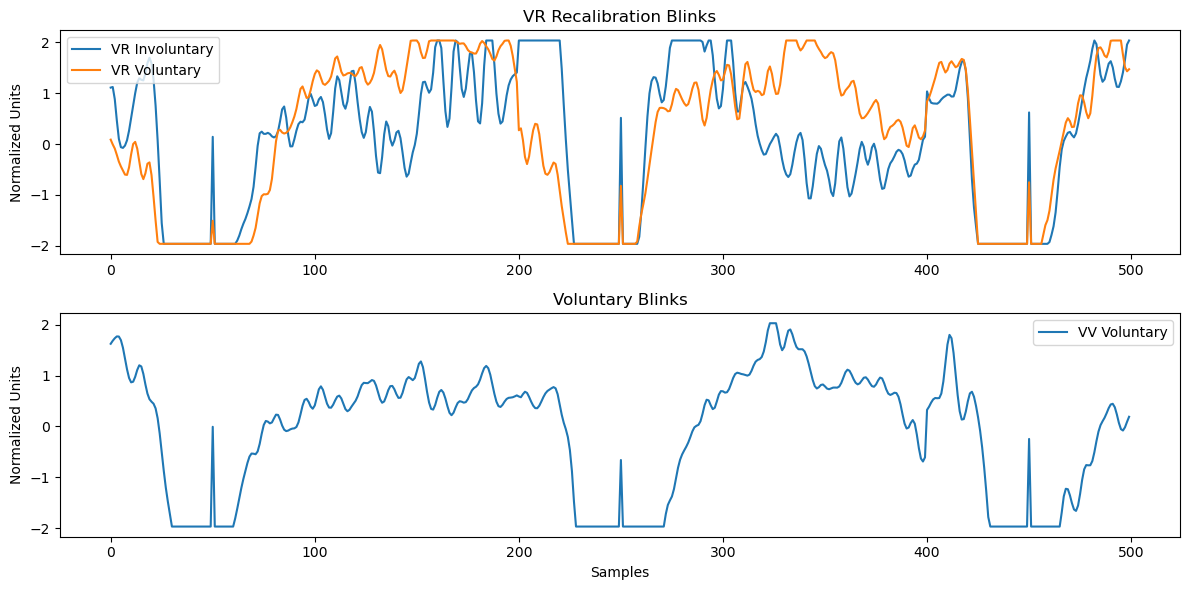

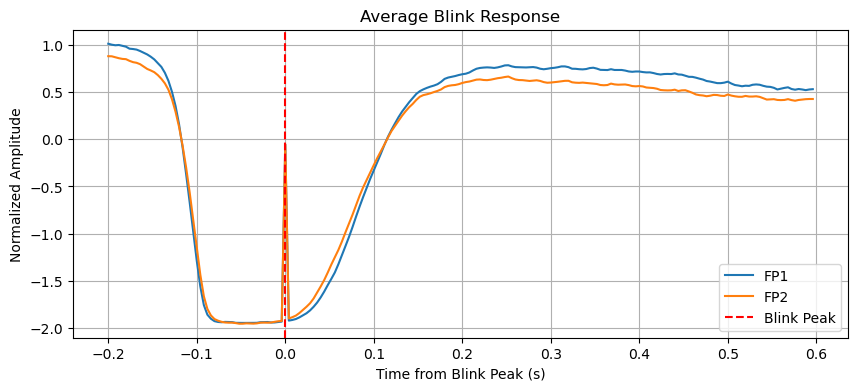

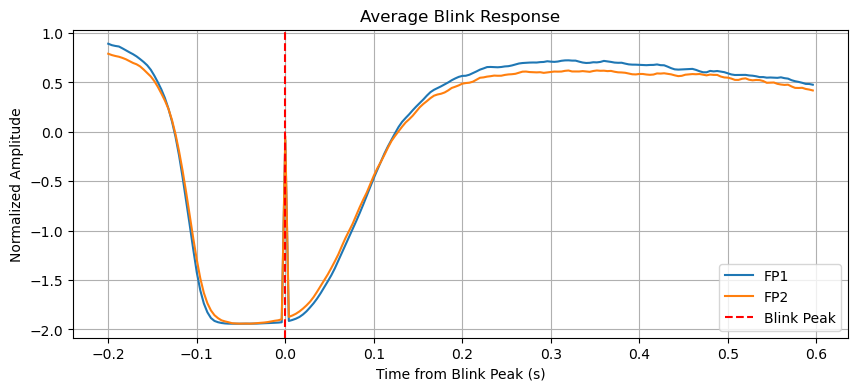

In [293]:
# Clean data
vr_clean = clean_vr_vv_data(vr_raw)
vv_clean = clean_vr_vv_data(vv_raw)

# Analyze
plot_vr_vv_comparison(vr_clean, vv_clean)
analyze_blink_epochs(vr_clean)  # Reuse same analysis function
analyze_blink_epochs(vv_clean)

# Save separately
vr_clean.to_feather("cleaned_vr_data.feather")
vv_clean.to_feather("cleaned_vv_data.feather")